In [1]:
import sys
sys.path.insert(1, '../')
sys.path.insert(1, '../regressions/')
sys.path.insert(1, '../tools/')


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from importlib import reload
import TSManager as ts
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')
%matplotlib inline

from CorrScreen import CorrScreenPredictor
from ElasticNet import ENPredictor
from KitchenSink import KSPredictor
import TSManager as ts
from TradingBot import TradingBot

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [3]:
df = pd.read_pickle('../pkl_data/train_prepared.pkl')
df.head()

,IC,VRP,BDI,SI,DP,PE,BM,CAPE,PCAPrice,BY,...,TERM,CAY,SIM,NOS,CPI,PCR,MA,OIL,SPX,RF
AsOfDate,,,,,,,,,,,,,,,,,,,,,
1990-06-08,NaN,0.737088,-0.152808,NaN,0.063979,7.524271,NaN,8.978524,3.616905,1.007418,...,0.50,-0.013576,0.715385,0.016941,0.046737,-1.622923,1.0,NaN,-0.012302,NaN
1990-06-11,NaN,-0.853208,-0.163823,NaN,0.063463,7.597792,NaN,9.051612,3.583706,1.009642,...,0.49,-0.013576,0.707692,0.016941,0.046737,-1.615366,1.0,NaN,0.008107,NaN
1990-06-12,NaN,-0.057387,-0.171766,NaN,0.062662,7.699009,NaN,9.167251,3.532720,1.009580,...,0.49,-0.013576,0.700000,0.016941,0.046737,-1.618868,1.0,NaN,0.012695,NaN
1990-06-13,NaN,1.332508,-0.180577,NaN,0.062894,7.674771,NaN,9.133460,3.547245,1.000056,...,0.47,-0.013576,0.692308,0.016941,0.046737,-1.625316,1.0,NaN,-0.003693,NaN
1990-06-14,NaN,1.204540,-0.189466,NaN,0.063241,7.636994,NaN,9.083400,3.569002,0.997689,...,0.46,-0.013576,0.684615,0.016941,0.046737,-1.620454,1.0,NaN,-0.005496,NaN


In [4]:
# constructing the target label
df['spx_tp130'] = df['SPX'].rolling(130).sum().shift(-129)
df = df.dropna(subset=['spx_tp130'])

# Kitchen Sink Regression

/home/rmfeng/miniconda3/envs/dsqf/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


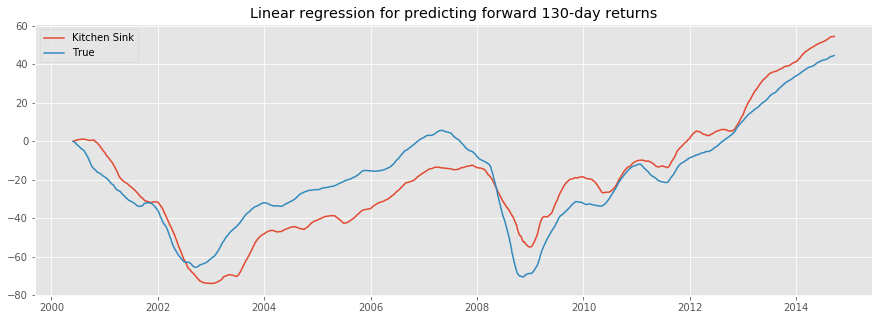

In [5]:
# test predictions

nbp = 180 # number of periods to be used
KSP = KSPredictor(df)
KSP.plot_predict(nbp)

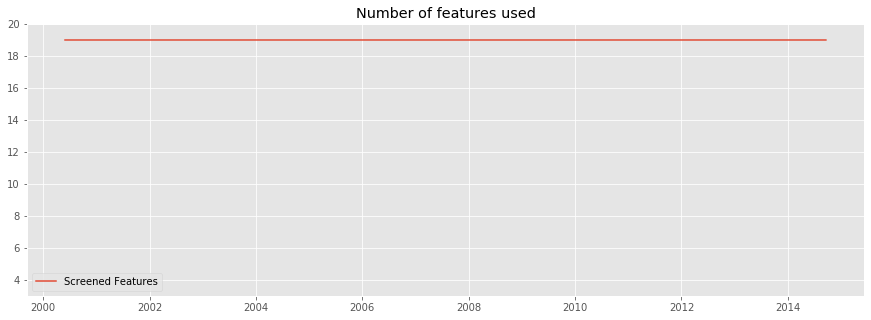

In [6]:
# plot total ft used per period

KSP.plot_screened_ft(nbp)

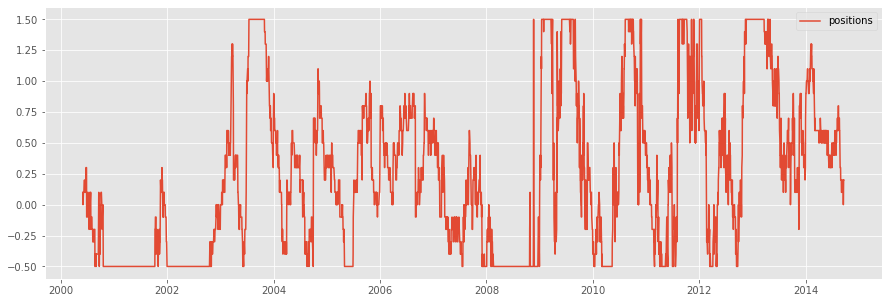

In [7]:
# plot positions

tb = TradingBot(df)

pos = tb.KS_pos(nbp)
plt.figure(figsize=(15,5))
plt.plot(df.index[2520:(2520+nbp*20)],pos,label='positions')
plt.legend()
plt.show()

-----------------------------------------------
number of years    : 14.29
annual return SPX  : 3.21 %  |  Sharpe: 0.09
annual return strat: 2.15 %  |  Sharpe: 0.05
-----------------------------------------------


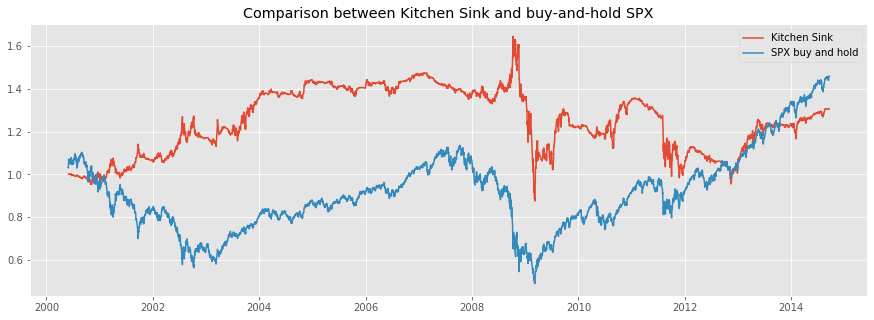

In [8]:
# plot wealth

tb.plot_wealth_KS(nbp)

## Debug

In [ ]:
nb_periods = nbp

In [ ]:
KS_pos = tb.KS_pos(nb_periods)

In [ ]:
timeline = tb.data.index[2520:(2520+nb_periods*20)]

In [ ]:
spx_buy_hold = np.exp(tb.data['SPX'][2520:(2520+nb_periods*20)]).cumprod()
strat_rt_in = pd.DataFrame([1 + (KS_pos[i] * (np.exp(tb.data['SPX'][2520:(2520+nb_periods*20)][i]) - 1)) for i in range(len(KS_pos))]).cumprod()

In [ ]:
# time
years = nb_periods*20/252

# bond returns
bond_rt = pd.DataFrame(tb._rf(nb_periods), columns=['rt']) / 360  # make it a daily rate
bond_tri = (bond_rt + 1).cumprod().fillna(1)

# returns
annual_return = 100*(strat_rt_in.iloc[-1,0]-1)/years
annual_return_spx = 100*(spx_buy_hold[-1]-1)/years
annual_bond_return = 100*(bond_tri['rt'].values[-1]-1)/years

annual_return, annual_return_spx, annual_bond_return

In [ ]:
spx_rt = np.exp(tb.data['SPX'][2520:(2520+nb_periods*20)])-1
spx_rt = spx_rt.dropna().tolist()
    
strat_rt = strat_rt_in.fillna(1).pct_change()
strat_rt = strat_rt.dropna().iloc[:,0].tolist()

In [ ]:
spx_sharpe = (annual_return_spx - annual_bond_return) / (np.std(spx_rt) * np.sqrt(252)) / 100
spx_sharpe

In [ ]:
np.std(spx_rt) * np.sqrt(252)

In [ ]:
strat_sharpe = (annual_return - annual_bond_return) / (np.std(strat_rt) * np.sqrt(252)) / 100
strat_sharpe

In [ ]:
np.std(strat_rt) * np.sqrt(252)

# Correlation Screening

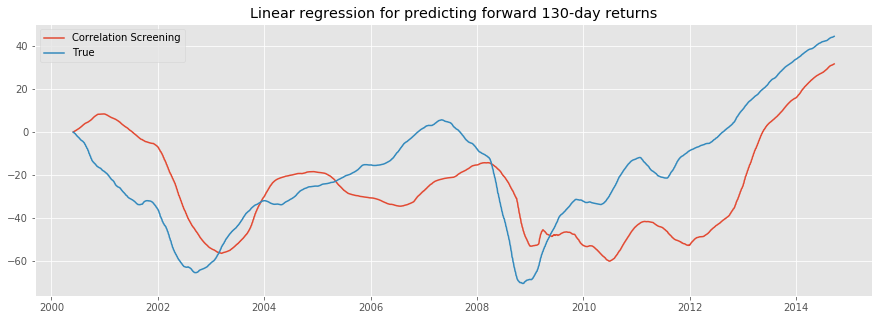

In [9]:
# test predictions

CSP = CorrScreenPredictor(df)
CSP.plot_predict(nbp)

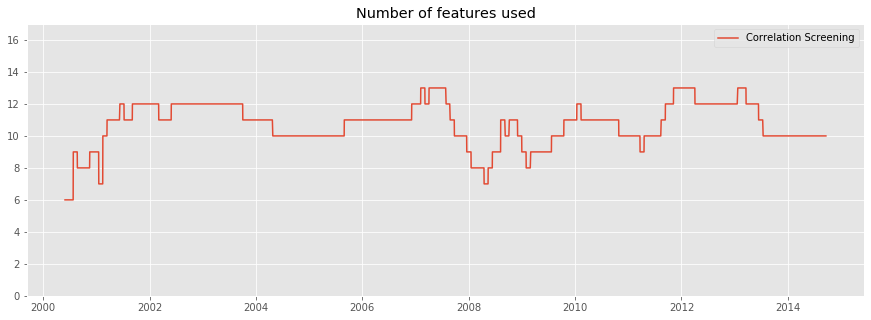

In [10]:
# plot total ft used per period

CSP.plot_screened_ft(nbp)

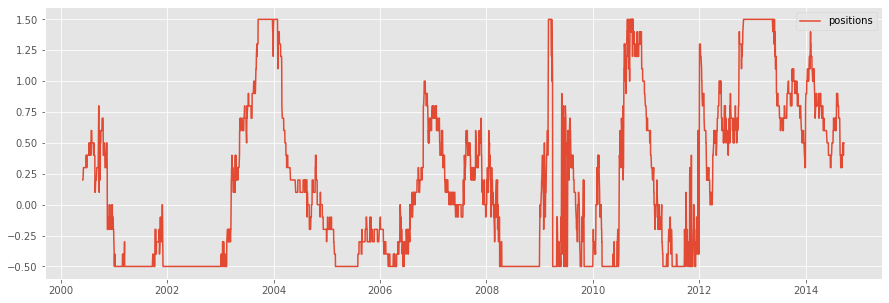

In [11]:
# plot positions

pos = tb.CS_pos(nbp)
plt.figure(figsize=(15,5))
plt.plot(df.index[2520:(2520+nbp*20)],pos,label='positions')
plt.legend()
plt.show()

-----------------------------------------------
number of years    : 14.29
annual return SPX  : 3.21 %  |  Sharpe: 0.09
annual return strat: 12.35 %  |  Sharpe: 0.91
-----------------------------------------------


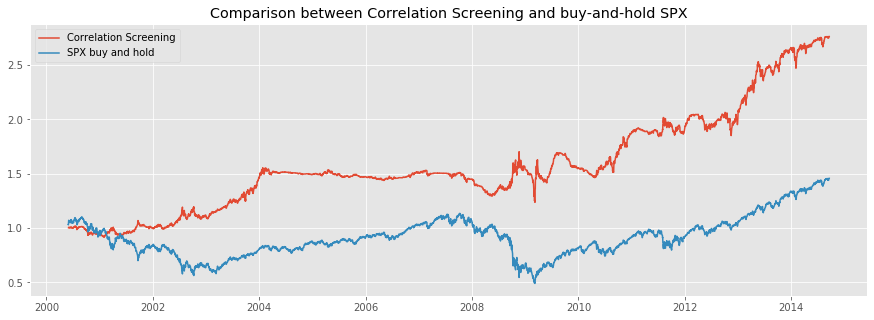

In [12]:
# plot wealth

tb.plot_wealth_CS(nbp)

# Real-Time Correlation Screening

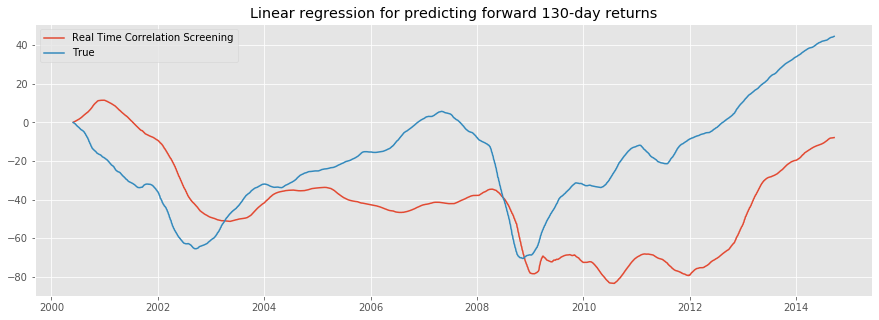

In [13]:
# test predictions

CSP = CorrScreenPredictor(df, RealTime=True)
CSP.plot_predict(nbp)

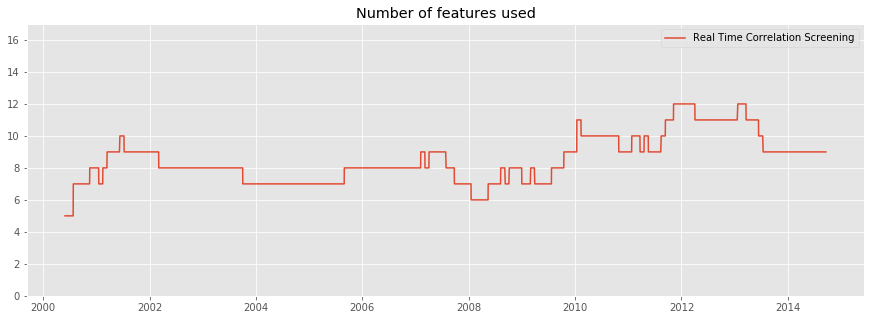

In [14]:
# plot total ft used per period

CSP.plot_screened_ft(nbp)

In [ ]:
# plot positions

pos = tb.CS_pos(nbp)
plt.figure(figsize=(15,5))
plt.plot(df.index[2520:(2520+nbp*20)],pos,label='positions')
plt.legend()
plt.show()

In [ ]:
# plot wealth

tb.plot_wealth_CS(nbp,RealTime=True)

# Elastic Net

In [ ]:
ENP = ENPredictor(df)
ENP.plot_predict(nbp)

In [ ]:
# plot positions

pos = tb.EN_pos(nbp)
plt.figure(figsize=(15,5))
plt.plot(df.index[2520:(2520+nbp*20)],pos,label='positions')
plt.legend()
plt.show()

In [ ]:
# plot wealth

tb.plot_wealth_EN(nbp,RealTime=True)

# Plot all four strategies on the same graph

In [ ]:
tb.plot_wealth_all(nbp)